# True Impact Shot Charting

This notebook contains step-by-step code snippets to load and explore NBA tracking data as it relates to off rebounding/fastbreak scenario scoring impacts. Walk through the cells below to interact with the data, generate features, and produce results. All relevant code classes are pre-imported, and the source code can be found and manipulated under the 'code' directory in the repo.

In [1]:
# Change this to any valid gameId in the source data
GAME_ID = "0022300869"

# Each source file has a dedicated processor class, use these to load and process src data
event_df = EventProcessor.load_game(GAME_ID)
tracking_df = TrackingProcessor.load_game(GAME_ID)
possession_df = PossessionProcessor.load_game(GAME_ID)

### 1. Begin by extracting and visualizing some data

In [2]:
anim = VisUtil(tracking_df)
anim.display_animation(possession_df.loc[possession_df["outcome"] == "FGM"].iloc[0])

### 2. Next, let's link the datasets together, and take a look at some raw data

In [13]:
# Extract transition events from the raw data, we will focus on the first example here
transition_events = EventProcessor.extract_transition_opportunities(event_df)
event = transition_events[0]

# Collect the timestamps at the start and end of the event, use that to collect coresponding tracking/possession info
start, end = EventProcessor.get_start_end_time_of_event(event)
moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, start, end)
possession = PossessionProcessor.extract_possession_by_timestamp(possession_df, end)

moment_df

,gameId,playerId,playerName,teamId,teamAbbr,period,wcTime,gcTime,scTime,x,y,z,gameDate
0,0022300869,1631128,Christian Braun,1610612743,DEN,1,1709430117960,681.1,24.00,-13.21,23.46,0.0,2024-03-02
1,0022300869,1627750,Jamal Murray,1610612743,DEN,1,1709430117960,681.1,24.00,-32.87,7.51,0.0,2024-03-02
2,0022300869,203932,Aaron Gordon,1610612743,DEN,1,1709430117960,681.1,24.00,-20.65,7.98,0.0,2024-03-02
3,0022300869,1629008,Michael Porter Jr.,1610612743,DEN,1,1709430117960,681.1,24.00,-39.25,1.33,0.0,2024-03-02
4,0022300869,203999,Nikola Jokic,1610612743,DEN,1,1709430117960,681.1,24.00,-44.23,1.12,0.0,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,0022300869,1630559,Austin Reaves,1610612747,LAL,1,1709430135360,663.7,7.63,27.94,-6.26,0.0,2024-03-02
4792,0022300869,2544,LeBron James,1610612747,LAL,1,1709430135360,663.7,7.63,43.28,10.76,0.0,2024-03-02
4793,0022300869,1626156,DAngelo Russell,1610612747,LAL,1,1709430135360,663.7,7.63,15.79,10.41,0.0,2024-03-02
4794,0022300869,203076,Anthony Davis,1610612747,LAL,1,1709430135360,663.7,7.63,36.27,-7.10,0.0,2024-03-02


### 3. Now that we are comfortable with the data, let's use our FeatureUtil to engineer some transition defense features

In [14]:
# Now we can generate our features
cross_3pt = FeatureUtil.find_ball_crossing_far_three_point_line(moment_df, possession["basketX"])
cross_half = FeatureUtil.find_ball_crossing_halfcourt(moment_df, possession["basketX"])
in_zone_of_death = FeatureUtil.find_ball_moment(moment_df, FeatureUtil.is_in_zone_of_death, possession["basketX"])

# Here, our FeatureUtil uses a set of boolean methods applied using vectorization to extract relevant game event timestamps
print(cross_3pt, cross_half, in_zone_of_death)

{'timestamp': 1709430122560, 'x': 18.22, 'y': -13.94} {'timestamp': 1709430117960, 'x': -40.83, 'y': 0.59} {'timestamp': 1709430117960, 'x': -40.83, 'y': 0.59}


### 4. Now, let's pivot to the shot charts. We begin by simply plotting the shot locations, and assigning them to labled regions

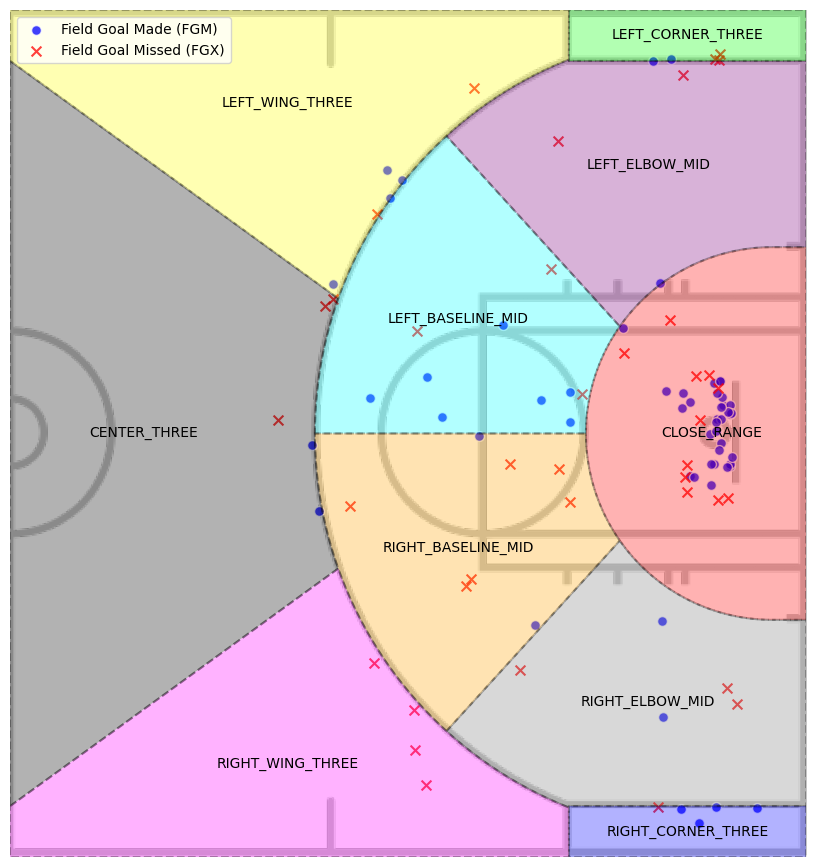

In [11]:
# First, we need to extract all the shot events, link the corresponding rebound event, and associate with coordinate data
shot_rebound_df = ActionProcessor.extract_shots_and_rebounds(event_df, tracking_df)

# Now that we have the shot/rebounds collected, we can use our FeatureUtil to engineer the regions, shots are classified by which polygon contains them
shot_rebound_classified_df = FeatureUtil.classify_shot_locations(shot_rebound_df, possession_df, FeatureUtil.classify_shot_region)

# Finally, plot the resulting data, mirror everything accross halfcourt
VisUtil.plot_shots_and_regions(shot_rebound_classified_df)

### 5. We will attach the shot classifications to our shot/rebound df and leverage it later on. We can then use this classified data to create rebound distribution plots

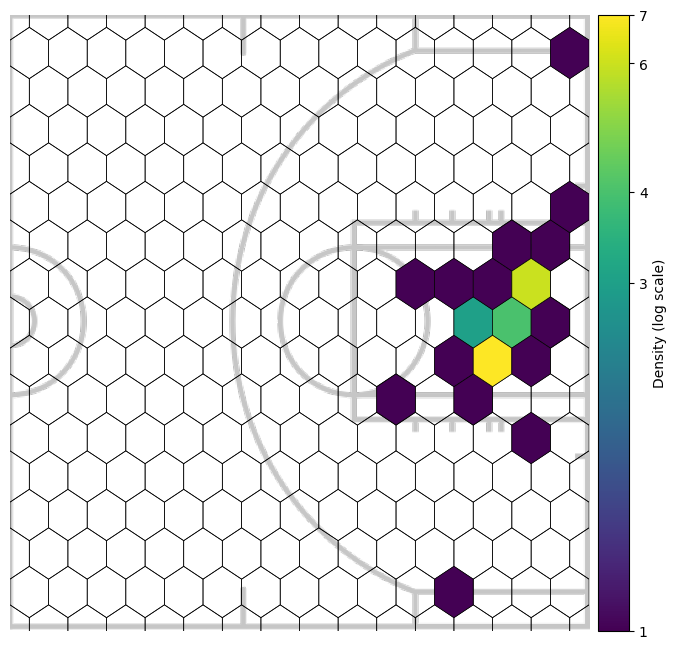

In [12]:
# We use hexbin plots to create probabilty mappings for rebounds based on where the shot originates from
hexbin_region_data_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)

# Here is what that distribution looks like across all regions
VisUtil.plot_court_hexmap(shot_rebound_classified_df, 'rebound_x', 'rebound_y')

### 6. We have classified shot data and rebound distributions. Next, we need a way to quantify the geospatial features of the court at the shot time to project which team has the best rebounding chances. We use Voroni cell diagrams to accomplish this

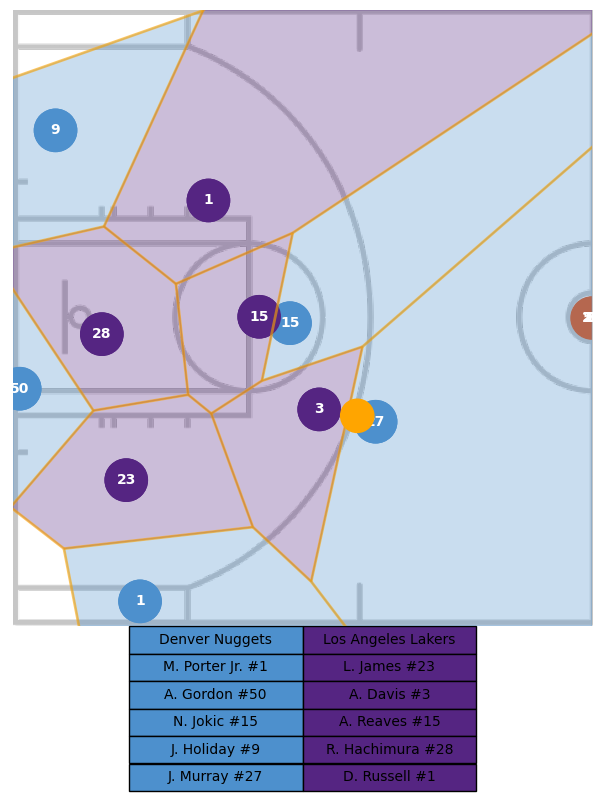

In [26]:
# Extract and individual shot attempt as an example
possession = shot_rebound_classified_df.iloc[-2]
moment_df = TrackingProcessor.extract_moment_from_timestamps(tracking_df, possession['shot_time'], possession['rebound_time'])

# Instantiate the VisUtil and plot the Voroni diagram at shot_time, cells are color coded according to the team that 'owns' them
anim = VisUtil(moment_df)
anim.plot_voronoi_at_timestamp(possession['shot_time'], possession["basketX"])

### 7. Time to start putting it all together! Let's overlay our Voroni plots with our rebound hexmap distributions, and calculate some rebound predictions

In [30]:
# We do this by passing in the shot data and mirroring it accross the court to match the rebound distribution
# Next, we assign a value based on the reb density of the cells owned by each player, and deriving a zero-sum projection based on that
reb_projections = StatsUtil.calculate_rebound_chances(moment_df, possession['shot_time'], possession['basketX'], hexbin_region_data_df, 41.75)
print(reb_projections)

# We then leverage vectorization to apply this procedure to all of our missed shot events, and assign the projections to the classified df
# NOTE: This step is computationally expensive, and can take ~45 mins to complete if processing the entire 10 game sample
reb_chances_df = StatsUtil.assign_rebound_chances_to_shots(shot_rebound_classified_df, tracking_df, hexbin_region_data_df)

({}, {})


100%|██████████| 186/186 [03:35<00:00,  1.16s/it]


### 8. Does it work? We can generate a couple metrics to determine our how well our projections line up with reality

0.07866396224003241


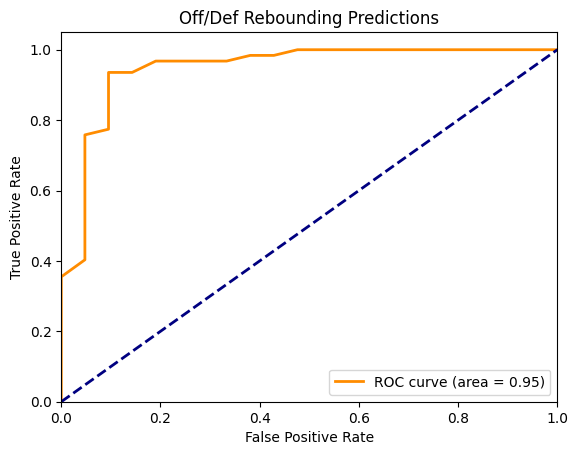

In [31]:
# First, pull off just the misses (as makes don't have projections)
misses = reb_chances_df.loc[reb_chances_df['made'] == False]

# Next, create a brier score. This indicates how much of the variance is unexplained by the model (lower is better)
print(FeatureUtil.calculate_brier_score_loss(misses))

# Finally, plot the area under the curve, which indicates the learning potential of our model (closer to 1.0 is better)
VisUtil.plot_auc(misses['dReb'], misses['def_reb_chance'], "Off/Def Rebounding Predictions")

### 8. We are almost ready to create our shot charts, but we need to layer our projections onto the base value model. Inspired by the True, Continuous shot chart model from Sloan '24, we will base this off a projected scoring model that takes into account FGM and FTM

In [28]:
# To calculate true points, we augment the provided ptsProduced col by scanning for free throw sequences folowing fouls
# Any points scored from the line are assigned to the inital shot attempt, and these projections can be used as the base ppp for our model
true_point_events = StatsUtil.calculate_true_points(event_df)
true_point_events['true_points_produced'].value_counts()

true_points_produced
0    80
2    79
3    25
1     3
Name: count, dtype: int64

### 9. Now we need to layer in our calculations, which requires assigning an expected point value based on our offensive rebounding chances

In [ ]:
true_impact_points_classified_df = pd.read_csv('./../data/results/true_impact_points_classified.csv', dtype={'dReb': pd.BooleanDtype()})

# Plot topographical heatmap using true impact points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="true_impact_points_produced")

# Plot topographical heatmap using points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="points_produced")

# Plot topographical heatmap using true points produced
VisUtil.plot_topographical_heatmap(true_impact_points_classified_df, weight_col="true_points_produced")